# Test du Laplacien

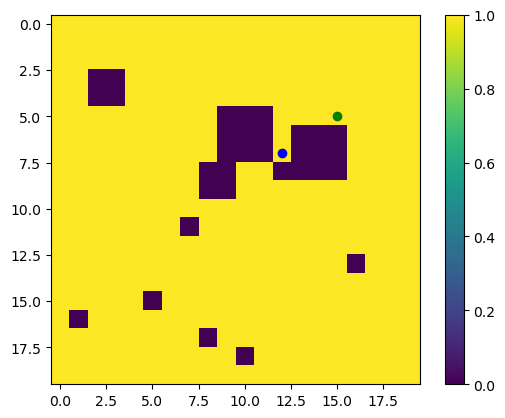

In [97]:
import phi.flow as phiflow
from snake_ai.envs import RandomObstaclesEnv
import numpy as np
import matplotlib.pyplot as plt

env = RandomObstaclesEnv(pixel=1, nb_obs=10, max_obs_size=3)
env.reset()
plt.imshow(env._free_position_mask)
plt.plot(env.goal.x, env.goal.y, 'go')
plt.plot(env.agent.position.x, env.agent.position.y, 'bo')
plt.colorbar()

<class 'phi.field._point_cloud.PointCloud'>


/home/rcremese/miniforge3/envs/snake-env/lib/python3.10/site-packages/phi/field/_field.py:142: FutureWarning: Instance checks on Grid are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, Grid)


<Figure size 1200x500 with 1 Axes>

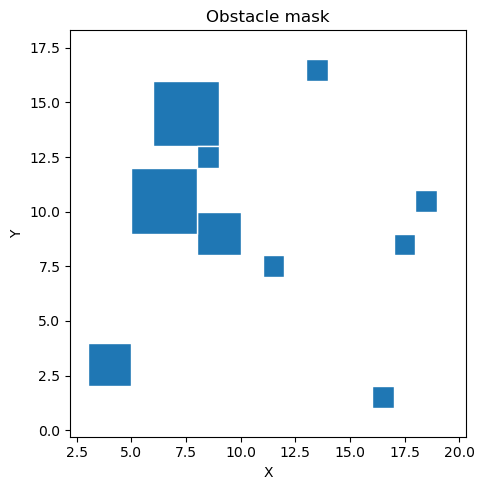

In [109]:
def convert_obstacles_to_geometry(obstacles):
    # Handle the case where there is only one obstacle
    return [
        phiflow.Box(
            x=(obs.left, obs.right),
            y=(obs.top, obs.bottom),
        )
        for obs in obstacles
    ]
obstacle_list = convert_obstacles_to_geometry(env.obstacles)
obstacle_mask = phiflow.mask(phiflow.union(obstacle_list))
print(type(obstacle_mask))
phiflow.vis.plot(obstacle_mask, title='Obstacle mask')
# grid_space = 100
# center = grid_space // 2
# one_tenth = grid_space // 10

# b = np.zeros((grid_space, grid_space))
# # b[0, :] = 100
# # b[-1, :] = 100
# # b[:, 0] = 100
# # b[:, -1] = 100
# # b[left:-left, left:-left] = 100
# b[10:20, 10:20] = 10
# b[center:center+one_tenth, center:center+one_tenth] = 1
# b = phiflow.tensor(b, phiflow.spatial('x,y'))
# print(b)
# bounds = phiflow.Box(x=1, y=1)
# centered_grid = phiflow.CenteredGrid(b, extrapolation=10, bounds=bounds)
# phiflow.vis.plot(centered_grid)

Box(x=(0, 20), y=(0, 20))
Box(x=(15, 16), y=(5, 6))
PointCloud[()]


<Figure size 1200x500 with 2 Axes>

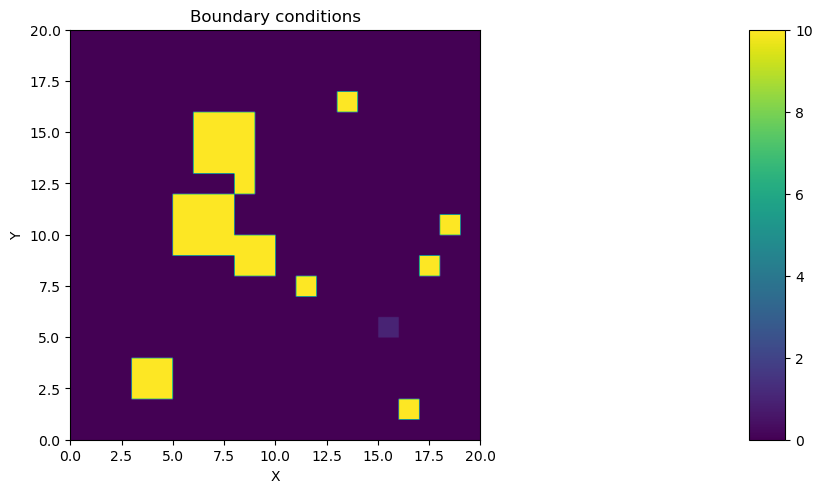

In [160]:
bounds = phiflow.Box(x=env.width, y=env.height)

goal = phiflow.Box(x=(env.goal.left, env.goal.right), y=(env.goal.top, env.goal.bottom))
print(bounds)
print(goal)
print(phiflow.mask(goal))
resolution = 10

boundary_contions = phiflow.CenteredGrid(0, bounds=bounds, extrapolation=10, resolution=phiflow.spatial(x=env.width * resolution, y= env.height * resolution))
boundary_contions = phiflow.field.where(phiflow.mask(goal), 1, boundary_contions)
boundary_contions = phiflow.field.where(obstacle_mask, 10, boundary_contions)
phiflow.vis.plot(boundary_contions, title='Boundary conditions')


<Figure size 1200x500 with 2 Axes>

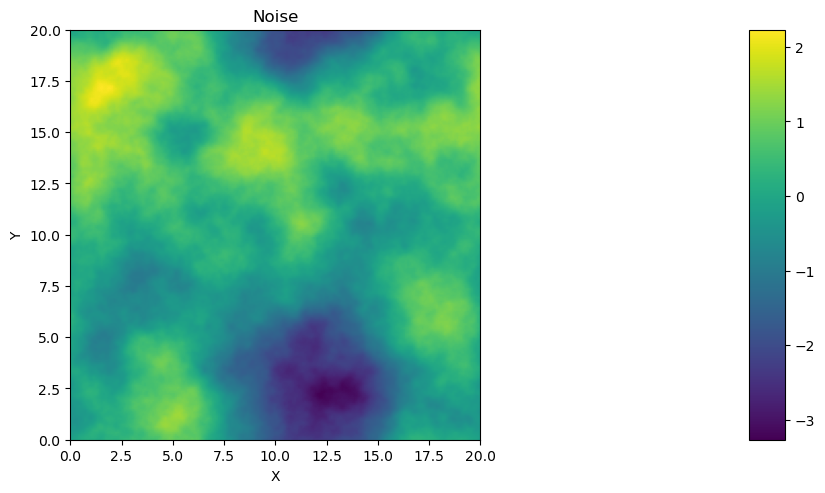

In [161]:
init_value = phiflow.CenteredGrid(phiflow.Noise(), bounds=bounds, resolution=boundary_contions.resolution)
phiflow.vis.plot(init_value, title='Noise')

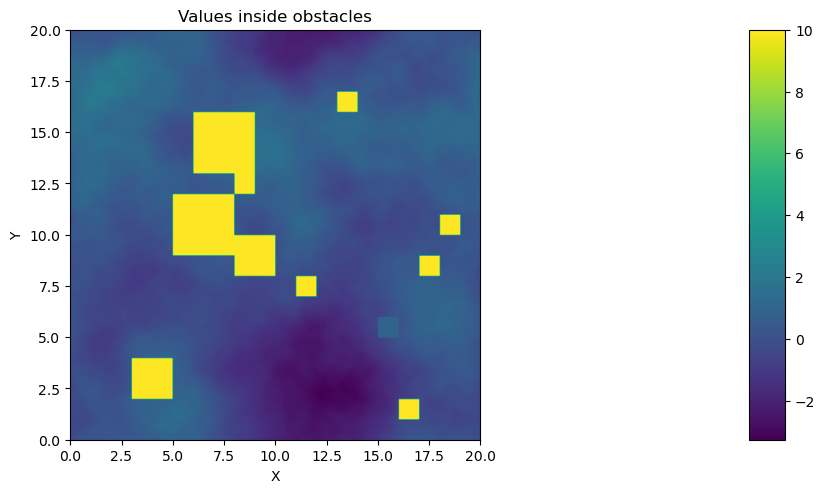

In [162]:
masked_value = phiflow.field.where(boundary_contions, boundary_contions, init_value)
phiflow.vis.plot(masked_value, title='Values inside obstacles')
solver = phiflow.Solve('auto', rel_tol=1e-5, x0=masked_value)

In [169]:
from functools import partial

@phiflow.jit_compile
def laplace_with_boundaries(grid : phiflow.CenteredGrid, boundary_contions : phiflow.CenteredGrid):
    temp_result = phiflow.field.laplace(grid)
    return phiflow.field.where(boundary_contions, boundary_contions, temp_result)
    
speedup_laplace = phiflow.jit_compile_linear(phiflow.field.laplace)

In [170]:
solution = phiflow.solve_linear(laplace_with_boundaries, boundary_contions, solve=solver, boundary_contions=boundary_contions)
phiflow.vis.plot(solution)

Diverged: 'Solve diverged within 163 iterations using Φ-ML CG-adaptive (numpy) .'

/home/rcremese/miniforge3/envs/snake-env/lib/python3.10/site-packages/phi/field/_field.py:142: FutureWarning: Instance checks on Grid are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, Grid)
/home/rcremese/miniforge3/envs/snake-env/lib/python3.10/site-packages/phi/field/_field.py:148: FutureWarning: Instance checks on PointCloud are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, PointCloud)


<Figure size 1200x500 with 2 Axes>

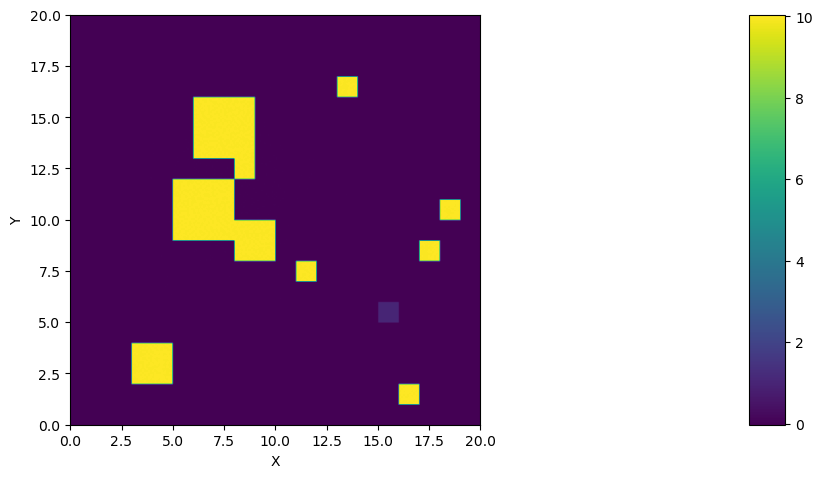

In [166]:
phiflow.vis.plot(phiflow.field.laplace(solution))